# Seattle non-residential buildings greenhouse gas emissions

This notebook aims at predicting the GHG emissio,s of non-residential buildings in the city of Seattle.
It relies on an official dataset available here: https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy
We are using a modified (by us) version of the database that you can find at this adress: inserer lien github

Another almost identical notebook exists and deals with energy consumption rather than GHG emissions.

## Initialization

In [32]:
# Packages import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings

In [33]:
# Loading the dataset
data = pd.read_csv(r'./Data/seattle_modeling_dataset.csv', sep = ',', low_memory = False)

In [34]:
data.describe()

,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,BuildingAge,elec_share,gas_share,steam_share
count,1600.000000,1600.000000,1600.000000,1600.000000,1.600000e+03,1600.000000,1.600000e+03,1062.000000,1600.000000,1.600000e+03,1.600000e+03,1.600000e+03,1.600000e+03,1.600000e+03,1600.000000,1600.000000,1600.000000,1.600000e+03,1600.000000,1600.000000
mean,47.615812,-122.332941,1.089375,4.088125,1.106321e+05,13096.407500,9.753572e+04,65.177024,75.289250,7.076933e+06,7.282962e+06,3.110444e+05,5.005476e+06,1.739623e+06,151.295469,1.602319,53.026875,6.962278e-01,0.281348,0.020625
std,0.048393,0.024538,1.141688,6.559611,1.854297e+05,42851.688379,1.624358e+05,28.348058,73.126280,1.318531e+07,1.341721e+07,2.540554e+06,9.397222e+06,4.966890e+06,366.177129,2.186006,32.548418,2.625905e-01,0.263745,0.089928
min,47.499170,-122.411820,0.000000,0.000000,1.128500e+04,0.000000,3.636000e+03,1.000000,1.500000,5.713320e+04,5.811420e+04,0.000000e+00,3.000000e+00,0.000000e+00,0.400000,0.010000,0.000000,8.631096e-07,0.000000,0.000000
25%,47.584535,-122.343280,1.000000,1.000000,2.931950e+04,0.000000,2.830400e+04,48.000000,36.900002,1.267434e+06,1.360588e+06,0.000000e+00,7.384795e+05,0.000000e+00,20.827500,0.360000,26.000000,4.851123e-01,0.000000,0.000000
50%,47.612335,-122.332895,1.000000,2.000000,4.890700e+04,0.000000,4.687900e+04,73.000000,54.650000,2.588369e+06,2.758547e+06,0.000000e+00,1.628064e+06,5.313785e+05,50.245000,0.890000,50.000000,6.951040e-01,0.248324,0.000000
75%,47.649635,-122.321815,1.000000,4.000000,1.040248e+05,0.000000,9.441750e+04,89.000000,85.699999,6.917330e+06,7.250945e+06,0.000000e+00,4.895578e+06,1.529470e+06,142.052500,1.910000,85.000000,9.992408e-01,0.497086,0.000000
max,47.733870,-122.258640,27.000000,99.000000,2.200000e+06,512608.000000,2.200000e+06,100.000000,834.400024,1.639460e+08,1.672071e+08,7.388547e+07,9.006050e+07,8.466809e+07,6330.910000,25.710000,115.000000,1.000003e+00,0.999999,0.766987


In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PrimaryPropertyType        1600 non-null   object 
 1   Neighborhood               1600 non-null   object 
 2   Latitude                   1600 non-null   float64
 3   Longitude                  1600 non-null   float64
 4   NumberofBuildings          1600 non-null   float64
 5   NumberofFloors             1600 non-null   int64  
 6   PropertyGFATotal           1600 non-null   int64  
 7   PropertyGFAParking         1600 non-null   int64  
 8   PropertyGFABuilding(s)     1600 non-null   int64  
 9   ListOfAllPropertyUseTypes  1600 non-null   object 
 10  LargestPropertyUseType     1600 non-null   object 
 11  ENERGYSTARScore            1062 non-null   float64
 12  SiteEUIWN(kBtu/sf)         1600 non-null   float64
 13  SiteEnergyUse(kBtu)        1600 non-null   float

#### Train & Test sets

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

X = data[['Latitude', 'Longitude', 
          'NumberofBuildings', 'NumberofFloors', 'BuildingAge',
          'PropertyGFATotal','PropertyGFAParking', 'PropertyGFABuilding(s)',
          'elec_share', 'gas_share', 'steam_share',
          'Neighborhood', 'LargestPropertyUseType']]

y = RobustScaler().fit_transform(data[['TotalGHGEmissions']]) # after several tries, we keep this y transformation
#y = np.log(data['SiteEnergyUseWN(kBtu)'])
#y = data['SiteEnergyUseWN(kBtu)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

## Models

We will include all remaining preprocessing in pipelines.

First, we are going to run several linear models: a LinearRegression (as baseline model), Ridge, Lasso and an ElasticNet regression.
Then, we will implement two ensemble methods: a Random Forest and a Gradient Boost.

All R², MAE and RMSE will be stored in a table to compare results, as well as training time for each model. 

In [37]:
# Selected Scikit-Learn modules
# Pipeline tools
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

# Transformers
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder

# Linear models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet

# Metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

## Linear models

### Baseline model: Linear Regression

In [38]:
# Transformer
transformer = make_column_transformer(
                                      (RobustScaler(),  
                                       # We choose the robust scaler because we have outliers
                                       # that we want to keep
                                              ['Latitude', 'Longitude', 
                                               'NumberofBuildings', 'NumberofFloors', 'BuildingAge',
                                               'PropertyGFATotal','PropertyGFAParking', 'PropertyGFABuilding(s)',
                                               'elec_share', 'gas_share', 'steam_share'
                                              ]),   
                                      (OneHotEncoder(handle_unknown='ignore'),
                                       # we decide to ignore unknown categories because some building types are
                                       # unique, and therefore only exist
                                       # in either the test or the train set.
                                              ['Neighborhood', 'LargestPropertyUseType'])
                                     )

This transformer is going ot be used in all linear_models.

In [39]:
## Linear Regression
start = time.time()

# Model fitting
model_lr = make_pipeline(transformer, LinearRegression())
model_lr.fit(X_train, y_train)

stop = time.time()
training_time = stop-start

# Predictions
y_pred = model_lr.predict(X_test)

# Results
Linear_Regression_base_results = {'Algorithm' : 'Linear Regression_base', 
                             'R² Train' : model_lr.score(X_train, y_train),
                             'R² Test' : model_lr.score(X_test, y_test), 
                             'MAE' : mean_absolute_error(y_test, y_pred), 
                             'RMSE' : np.sqrt(mean_squared_error(y_test, y_pred)),
                             'Training time (sec)' : training_time}

Results_table = pd.DataFrame.from_dict([Linear_Regression_base_results])
Results_table

,Algorithm,R² Train,R² Test,MAE,RMSE,Training time (sec)
0,Linear Regression_base,0.540229,0.683342,0.941906,1.908531,0.029994


The linear regression model performs quite poorly. We will try a cross-validation to see if any improvement occurs before moving to different modelizations.

In [40]:
# Cross-validation - Linear Regression
from sklearn.model_selection import GridSearchCV
start = time.time()

params = {'linearregression__fit_intercept' : [True, False]}
grid = GridSearchCV(model_lr, param_grid = params, cv=5)
grid.fit(X_train, y_train)

stop = time.time()
training_time = stop-start

y_pred = grid.predict(X_test)

Linear_Regression_CV_results = {'Algorithm' : 'Linear Regression', 
                             'R² Train' : grid.score(X_train, y_train),
                             'R² Test' : grid.score(X_test, y_test),  
                             'MAE' : mean_absolute_error(y_test, y_pred), 
                             'RMSE' : np.sqrt(mean_squared_error(y_test, y_pred)),
                             'Training time (sec)' : training_time}

Results_table = Results_table.append(pd.DataFrame.from_dict([Linear_Regression_CV_results]))
Results_table

,Algorithm,R² Train,R² Test,MAE,RMSE,Training time (sec)
0,Linear Regression_base,0.540229,0.683342,0.941906,1.908531,0.029994
0,Linear Regression,0.540229,0.683342,0.941906,1.908531,0.374832


The implementation of a 5-fold cross-validation and a fit of an intercept or not has not changed the result much. Let's try a more sophisticated model.

### Ridge regression

In [41]:
from sklearn.linear_model import Ridge
warnings.filterwarnings('ignore')
start = time.time()

# Cross-validated - Ridge Regression
alphas = np.logspace(-5, 1, num = 50)
params = {'ridge__alpha' : alphas}
model_ridge = make_pipeline(transformer, Ridge())
    
grid = GridSearchCV(model_ridge, param_grid = params, cv=5)

grid.fit(X_train, y_train)
    
stop = time.time()
training_time = stop-start

y_pred = grid.predict(X_test)

Ridge_Regression_results = {'Algorithm' : 'Ridge Regression', 
                             'R² Train' : grid.score(X_train, y_train),
                             'R² Test' : grid.score(X_test, y_test), 
                             'MAE' : mean_absolute_error(y_test, y_pred), 
                             'RMSE' : np.sqrt(mean_squared_error(y_test, y_pred)),
                             'Training time (sec)' : training_time}

Results_table = Results_table.append(pd.DataFrame.from_dict([Ridge_Regression_results]))
Results_table

,Algorithm,R² Train,R² Test,MAE,RMSE,Training time (sec)
0,Linear Regression_base,0.540229,0.683342,0.941906,1.908531,0.029994
0,Linear Regression,0.540229,0.683342,0.941906,1.908531,0.374832
0,Ridge Regression,0.025371,0.007239,1.384571,3.379298,6.487739


As seen in the consumption notebook, the Ridge regression performs very poorly. Let's try the Lasso.

### Lasso Regression

In [42]:
from sklearn.linear_model import Lasso
warnings.filterwarnings('ignore')
start = time.time()

# Cross-validated - Lasso Regression
alphas = np.logspace(-5, 1, num = 50)
params = {'lasso__alpha' : alphas}

model_lasso = make_pipeline(transformer, Lasso())

grid = GridSearchCV(model_lasso, param_grid = params, cv=5)
grid.fit(X_train, y_train)

stop = time.time()
training_time = stop-start

y_pred = grid.predict(X_test)

Lasso_Regression_results = {'Algorithm' : 'Lasso Regression', 
                             'R² Train' : grid.score(X_train, y_train),
                             'R² Test' : grid.score(X_test, y_test),
                             'MAE' : mean_absolute_error(y_test, y_pred), 
                             'RMSE' : np.sqrt(mean_squared_error(y_test, y_pred)),
                             'Training time (sec)' : training_time}

Results_table = Results_table.append(pd.DataFrame.from_dict([Lasso_Regression_results]))
Results_table

,Algorithm,R² Train,R² Test,MAE,RMSE,Training time (sec)
0,Linear Regression_base,0.540229,0.683342,0.941906,1.908531,0.029994
0,Linear Regression,0.540229,0.683342,0.941906,1.908531,0.374832
0,Ridge Regression,0.025371,0.007239,1.384571,3.379298,6.487739
0,Lasso Regression,0.538602,0.680886,0.926170,1.915919,36.177139


### Lasso CV

In [43]:
from sklearn.linear_model import LassoCV
warnings.filterwarnings('ignore')
start = time.time()

# Automatically cross-validated - Lasso Regression
alphas = np.logspace(-5, 1, num = 50)

model_lassoCV = make_pipeline(transformer, LassoCV(alphas = alphas))
model_lassoCV.fit(X_train, y_train)

stop = time.time()
training_time = stop-start

y_pred = model_lassoCV.predict(X_test)

Lasso_Regression_CV_results = {'Algorithm' : 'Lasso Regression_autoCV', 
                             'R² Train' : model_lassoCV.score(X_train, y_train),
                             'R² Test' : model_lassoCV.score(X_test, y_test), 
                             'MAE' : mean_absolute_error(y_test, y_pred), 
                             'RMSE' : np.sqrt(mean_squared_error(y_test, y_pred)),
                             'Training time (sec)' : training_time}

Results_table = Results_table.append(pd.DataFrame.from_dict([Lasso_Regression_CV_results]))
Results_table

,Algorithm,R² Train,R² Test,MAE,RMSE,Training time (sec)
0,Linear Regression_base,0.540229,0.683342,0.941906,1.908531,0.029994
0,Linear Regression,0.540229,0.683342,0.941906,1.908531,0.374832
0,Ridge Regression,0.025371,0.007239,1.384571,3.379298,6.487739
0,Lasso Regression,0.538602,0.680886,0.926170,1.915919,36.177139
0,Lasso Regression_autoCV,0.539664,0.681448,0.931374,1.914232,13.975359


With Lasso, the fitting of the data is better but still doesnt reach the baseline model. To the contrary it displays a lower RMSE than the baseline, meaning that it performs better when handling unknown data! 

### ElasticNet

In [44]:
# Model fitting
warnings.filterwarnings('ignore')
start = time.time()
model_EN = make_pipeline(transformer, ElasticNet())
model_EN.fit(X_train, y_train)

stop = time.time()
training_time = stop-start

# Predictions
y_pred = model_EN.predict(X_test)

# Results
ElasticNet_noCV_results = {'Algorithm' : 'Elastic Net_noCV', 
                             'R² Train' : model_EN.score(X_train, y_train),
                             'R² Test' : model_EN.score(X_test, y_test),
                             'MAE' : mean_absolute_error(y_test, y_pred), 
                             'RMSE' : np.sqrt(mean_squared_error(y_test, y_pred)),
                             'Training time (sec)' : training_time}

Results_table = Results_table.append(pd.DataFrame.from_dict([ElasticNet_noCV_results]))
Results_table

,Algorithm,R² Train,R² Test,MAE,RMSE,Training time (sec)
0,Linear Regression_base,0.540229,0.683342,0.941906,1.908531,0.029994
0,Linear Regression,0.540229,0.683342,0.941906,1.908531,0.374832
0,Ridge Regression,0.025371,0.007239,1.384571,3.379298,6.487739
0,Lasso Regression,0.538602,0.680886,0.926170,1.915919,36.177139
0,Lasso Regression_autoCV,0.539664,0.681448,0.931374,1.914232,13.975359
0,Elastic Net_noCV,0.245906,0.175255,1.206384,3.080094,0.019991


Without any tuning of the hyperparameters, the ElasticNet model is outperformed by the standard Linear regression.

In [45]:
# Cross-validation - ElasticNet Regression
warnings.filterwarnings('ignore')
start = time.time()

alphas = np.logspace(-5, 1, num = 50)
l1_ratios = np.arange(0, 1, step = 0.05)

params = {'elasticnet__max_iter' : [100],
          'elasticnet__alpha' : alphas,
          'elasticnet__l1_ratio' : l1_ratios}

grid = GridSearchCV(model_EN, param_grid = params, cv=5)
grid.fit(X_train, y_train)

stop = time.time()
training_time = stop-start

y_pred = grid.predict(X_test)

print(grid.best_params_)


ElasticNet_results = {'Algorithm' : 'Elastic Net', 
                             'R² Train' : grid.score(X_train, y_train),
                             'R² Test' : grid.score(X_test, y_test), 
                             'MAE' : mean_absolute_error(y_test, y_pred), 
                             'RMSE' : np.sqrt(mean_squared_error(y_test, y_pred)),
                             'Training time (sec)' : training_time}

Results_table = Results_table.append(pd.DataFrame.from_dict([ElasticNet_results]))
Results_table

{'elasticnet__alpha': 0.0009102981779915217, 'elasticnet__l1_ratio': 0.9500000000000001, 'elasticnet__max_iter': 100}


,Algorithm,R² Train,R² Test,MAE,RMSE,Training time (sec)
0,Linear Regression_base,0.540229,0.683342,0.941906,1.908531,0.029994
0,Linear Regression,0.540229,0.683342,0.941906,1.908531,0.374832
0,Ridge Regression,0.025371,0.007239,1.384571,3.379298,6.487739
0,Lasso Regression,0.538602,0.680886,0.926170,1.915919,36.177139
0,Lasso Regression_autoCV,0.539664,0.681448,0.931374,1.914232,13.975359
0,Elastic Net_noCV,0.245906,0.175255,1.206384,3.080094,0.019991
0,Elastic Net,0.539021,0.679311,0.929609,1.920641,141.505520


With different settings, the ElasticNet is now way better performing, mostly with new data.

## Ensemble methods

### Random Forest, no Cross-validation

In [46]:
from sklearn.ensemble import RandomForestRegressor
warnings.filterwarnings('ignore')
start = time.time()

model_RF = make_pipeline(transformer, RandomForestRegressor())

model_RF.fit(X_train, y_train)

stop = time.time()
training_time = stop-start

y_pred = model_RF.predict(X_test)


RandomForest_nocv_results = {'Algorithm' : 'Random Forest_noCV', 
                        'R² Train' : model_RF.score(X_train, y_train),
                        'R² Test' : model_RF.score(X_test, y_test),
                        'MAE' : mean_absolute_error(y_test, y_pred), 
                        'RMSE' : np.sqrt(mean_squared_error(y_test, y_pred)),
                        'Training time (sec)' : training_time}

Results_table = Results_table.append(pd.DataFrame.from_dict([RandomForest_nocv_results]))
Results_table

,Algorithm,R² Train,R² Test,MAE,RMSE,Training time (sec)
0,Linear Regression_base,0.540229,0.683342,0.941906,1.908531,0.029994
0,Linear Regression,0.540229,0.683342,0.941906,1.908531,0.374832
0,Ridge Regression,0.025371,0.007239,1.384571,3.379298,6.487739
0,Lasso Regression,0.538602,0.680886,0.926170,1.915919,36.177139
0,Lasso Regression_autoCV,0.539664,0.681448,0.931374,1.914232,13.975359
0,Elastic Net_noCV,0.245906,0.175255,1.206384,3.080094,0.019991
0,Elastic Net,0.539021,0.679311,0.929609,1.920641,141.505520
0,Random Forest_noCV,0.951017,0.776213,0.649900,1.604435,2.350288


### Random Forest with CV

In [47]:
#warnings.filterwarnings('ignore')
#start = time.time()
#
#model_RF = make_pipeline(transformer, RandomForestRegressor())
#
#params = {'randomforestregressor__n_estimators' : [50, 100, 300, 500],
#          'randomforestregressor__min_samples_split' : [2, 3, 4],
#          'randomforestregressor__max_features' : ['auto', 'sqrt', '1.0'],
#          'randomforestregressor__oob_score' : ['True', 'False']}
#
#grid = GridSearchCV(model_RF, param_grid = params, cv=5)
#grid.fit(X_train, y_train)
#
#stop = time.time()
#training_time = stop-start
#
#y_pred = grid.predict(X_test)
#
#print(grid.best_params_)
#
#
#RandomForest_results = {'Algorithm' : 'Random Forest', 
#                        'R² Train' : grid.score(X_train, y_train),
#                        'R² Test' : grid.score(X_test, y_test),
#                        'MAE' : mean_absolute_error(y_test, y_pred), 
#                        'RMSE' : np.sqrt(mean_squared_error(y_test, y_pred)),
#                        'Training time (sec)' : training_time}
#
#Results_table = Results_table.append(pd.DataFrame.from_dict([RandomForest_results]))
#Results_table

In [48]:
warnings.filterwarnings('ignore')
start = time.time()

model_RF = make_pipeline(transformer, RandomForestRegressor())

params = {'randomforestregressor__n_estimators' : [50],
          'randomforestregressor__min_samples_split' : [2],
          'randomforestregressor__max_features' : ['auto'],
          'randomforestregressor__oob_score' : ['False']}

grid = GridSearchCV(model_RF, param_grid = params, cv=5)
grid.fit(X_train, y_train)

stop = time.time()
training_time = stop-start

y_pred = grid.predict(X_test)

print(grid.best_params_)


RandomForest_results = {'Algorithm' : 'Random Forest', 
                        'R² Train' : grid.score(X_train, y_train),
                        'R² Test' : grid.score(X_test, y_test),
                        'MAE' : mean_absolute_error(y_test, y_pred), 
                        'RMSE' : np.sqrt(mean_squared_error(y_test, y_pred)),
                        'Training time (sec)' : training_time}

Results_table = Results_table.append(pd.DataFrame.from_dict([RandomForest_results]))
Results_table

{'randomforestregressor__max_features': 'auto', 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 50, 'randomforestregressor__oob_score': 'False'}


,Algorithm,R² Train,R² Test,MAE,RMSE,Training time (sec)
0,Linear Regression_base,0.540229,0.683342,0.941906,1.908531,0.029994
0,Linear Regression,0.540229,0.683342,0.941906,1.908531,0.374832
0,Ridge Regression,0.025371,0.007239,1.384571,3.379298,6.487739
0,Lasso Regression,0.538602,0.680886,0.926170,1.915919,36.177139
0,Lasso Regression_autoCV,0.539664,0.681448,0.931374,1.914232,13.975359
0,Elastic Net_noCV,0.245906,0.175255,1.206384,3.080094,0.019991
0,Elastic Net,0.539021,0.679311,0.929609,1.920641,141.505520
0,Random Forest_noCV,0.951017,0.776213,0.649900,1.604435,2.350288
0,Random Forest,0.942068,0.709761,0.685297,1.827184,5.625592


Clearly, there is a huge improvement when we switch to ensemble methods.
The random forest regressor out-performs every single other model we fitted, and by far.
It's interesting to note that the cross-validation does improve just a tiny bit the random forest performance, despite the multiple tries we made (similarly to the consumption notebook).

Let's now see if the boosting methods are as good.

### Gradient Boost

In [49]:
#from sklearn.ensemble import GradientBoostingRegressor
#warnings.filterwarnings('ignore')
#
#start = time.time()
#
#model_GB = make_pipeline(transformer, GradientBoostingRegressor())
#lambdas = np.logspace(-5, 1, num = 50)
#
#params = {'gradientboostingregressor__n_estimators' : [500],
#          'gradientboostingregressor__learning_rate' : lambdas,
#          'gradientboostingregressor__min_samples_leaf' : [1,3],
#          'gradientboostingregressor__max_depth' : [3,5],
#          }
#
#grid = GridSearchCV(model_GB, param_grid = params, cv=5)
#grid.fit(X_train, y_train)
#
#stop = time.time()
#training_time = stop-start
#
#y_pred = grid.predict(X_test)
#
#print(grid.best_params_)
#
#
#GradientBoost_results = {'Algorithm' : 'Gradient Boosting', 
#                        'R² Train' : grid.score(X_train, y_train),
#                        'R² Test' : grid.score(X_test, y_test),
#                        'MAE' : mean_absolute_error(y_test, y_pred), 
#                        'RMSE' : np.sqrt(mean_squared_error(y_test, y_pred)),
#                        'Training time (sec)' : training_time}
#
#Results_table = Results_table.append(pd.DataFrame.from_dict([GradientBoost_results]))
#Results_table

In [50]:
from sklearn.ensemble import GradientBoostingRegressor
warnings.filterwarnings('ignore')

start = time.time()

model_GB = make_pipeline(transformer, GradientBoostingRegressor())
lambdas = [0.026826957952797246]

params = {'gradientboostingregressor__n_estimators' : [500],
          'gradientboostingregressor__learning_rate' : lambdas,
          'gradientboostingregressor__min_samples_leaf' : [3],
          'gradientboostingregressor__max_depth' : [3],
          }

grid = GridSearchCV(model_GB, param_grid = params, cv=5)
grid.fit(X_train, y_train)

stop = time.time()
training_time = stop-start

y_pred = grid.predict(X_test)

print(grid.best_params_)


GradientBoost_results = {'Algorithm' : 'Gradient Boosting_best_params', 
                        'R² Train' : grid.score(X_train, y_train),
                        'R² Test' : grid.score(X_test, y_test),
                        'MAE' : mean_absolute_error(y_test, y_pred), 
                        'RMSE' : np.sqrt(mean_squared_error(y_test, y_pred)),
                        'Training time (sec)' : training_time}

Results_table = Results_table.append(pd.DataFrame.from_dict([GradientBoost_results]))
Results_table

{'gradientboostingregressor__learning_rate': 0.026826957952797246, 'gradientboostingregressor__max_depth': 3, 'gradientboostingregressor__min_samples_leaf': 3, 'gradientboostingregressor__n_estimators': 500}


,Algorithm,R² Train,R² Test,MAE,RMSE,Training time (sec)
0,Linear Regression_base,0.540229,0.683342,0.941906,1.908531,0.029994
0,Linear Regression,0.540229,0.683342,0.941906,1.908531,0.374832
0,Ridge Regression,0.025371,0.007239,1.384571,3.379298,6.487739
0,Lasso Regression,0.538602,0.680886,0.926170,1.915919,36.177139
0,Lasso Regression_autoCV,0.539664,0.681448,0.931374,1.914232,13.975359
0,Elastic Net_noCV,0.245906,0.175255,1.206384,3.080094,0.019991
0,Elastic Net,0.539021,0.679311,0.929609,1.920641,141.505520
0,Random Forest_noCV,0.951017,0.776213,0.649900,1.604435,2.350288
0,Random Forest,0.942068,0.709761,0.685297,1.827184,5.625592
0,Gradient Boosting_best_params,0.942632,0.803970,0.634873,1.501638,7.605732


This time, the Gradient boost model is not better than the Random Forest. It has quite similar results. When adding the Energy Star Score, we'll run both of them.

### Energy star score

We are now going to check whether adding the Energy Star Score has an impact on improving the predictions or not. Note that we only have 1062 observations, we have to filter again the whole dataset and re-do the split and predictions.
Considering the relative similar observed performances of them, we are going run Random Forest and Gradient Boost.

In [51]:
data_ESS = data[~(data['ENERGYSTARScore'].isnull())]

In [52]:
X = data_ESS[['Latitude', 'Longitude', 
          'NumberofBuildings', 'NumberofFloors', 'BuildingAge',
          'PropertyGFATotal','PropertyGFAParking', 'PropertyGFABuilding(s)',
          'elec_share', 'gas_share', 'steam_share',
          'ENERGYSTARScore',
          'Neighborhood', 'LargestPropertyUseType']]

y = RobustScaler().fit_transform(data_ESS[['TotalGHGEmissions']])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [53]:
# Transformer
transformer = make_column_transformer(
                                      (RobustScaler(),  
                                       # We choose the robust scaler because we have outliers
                                       # that we want to keep
                                              ['Latitude', 'Longitude', 
                                               'NumberofBuildings', 'NumberofFloors', 'BuildingAge',
                                               'PropertyGFATotal','PropertyGFAParking', 'PropertyGFABuilding(s)',
                                               'elec_share', 'gas_share', 'steam_share'
                                              ]),   
                                      (OneHotEncoder(handle_unknown='ignore'),
                                       # we decide to ignore unknown categories because some building types are
                                       # unique, and therefore only exist
                                       # in either the test or the train set.
                                              ['Neighborhood', 'LargestPropertyUseType'])
                                     )


In [54]:
# Cross-validation - Linear Regression
from sklearn.model_selection import GridSearchCV
start = time.time()

model_lr = make_pipeline(transformer, LinearRegression())
params = {'linearregression__fit_intercept' : [True, False]}
grid = GridSearchCV(model_lr, param_grid = params, cv=5)
grid.fit(X_train, y_train)

stop = time.time()
training_time = stop-start

y_pred = grid.predict(X_test)

Linear_Regression_CV_results = {'Algorithm' : 'Linear Regression ESS', 
                             'R² Train' : grid.score(X_train, y_train),
                             'R² Test' : grid.score(X_test, y_test), 
                             'MAE' : mean_absolute_error(y_test, y_pred), 
                             'RMSE' : np.sqrt(mean_squared_error(y_test, y_pred)),
                             'Training time (sec)' : training_time}

Results_table = Results_table.append(pd.DataFrame.from_dict([Linear_Regression_CV_results]))
Results_table

,Algorithm,R² Train,R² Test,MAE,RMSE,Training time (sec)
0,Linear Regression_base,0.540229,0.683342,0.941906,1.908531,0.029994
0,Linear Regression,0.540229,0.683342,0.941906,1.908531,0.374832
0,Ridge Regression,0.025371,0.007239,1.384571,3.379298,6.487739
0,Lasso Regression,0.538602,0.680886,0.926170,1.915919,36.177139
0,Lasso Regression_autoCV,0.539664,0.681448,0.931374,1.914232,13.975359
0,Elastic Net_noCV,0.245906,0.175255,1.206384,3.080094,0.019991
0,Elastic Net,0.539021,0.679311,0.929609,1.920641,141.505520
0,Random Forest_noCV,0.951017,0.776213,0.649900,1.604435,2.350288
0,Random Forest,0.942068,0.709761,0.685297,1.827184,5.625592
0,Gradient Boosting_best_params,0.942632,0.803970,0.634873,1.501638,7.605732


In [55]:
# Gradientboost
from sklearn.ensemble import GradientBoostingRegressor
warnings.filterwarnings('ignore')

start = time.time()

model_GB = make_pipeline(transformer, GradientBoostingRegressor())
lambdas = np.logspace(-5, 1, num = 50)

params = {'gradientboostingregressor__n_estimators' : [500],
          'gradientboostingregressor__learning_rate' : lambdas,
          'gradientboostingregressor__min_samples_leaf' : [1],
          'gradientboostingregressor__max_depth' : [3],
          }

grid = GridSearchCV(model_GB, param_grid = params, cv=5)
grid.fit(X_train, y_train)

stop = time.time()
training_time = stop-start

y_pred = grid.predict(X_test)

print(grid.best_params_)


GradientBoost_ESS_results = {'Algorithm' : 'Gradient Boosting_ESS', 
                        'R² Train' : grid.score(X_train, y_train),
                        'R² Test' : grid.score(X_test, y_test), 
                        'MAE' : mean_absolute_error(y_test, y_pred), 
                        'RMSE' : np.sqrt(mean_squared_error(y_test, y_pred)),
                        'Training time (sec)' : training_time}

Results_table = Results_table.append(pd.DataFrame.from_dict([GradientBoost_ESS_results]))
Results_table

{'gradientboostingregressor__learning_rate': 0.08286427728546843, 'gradientboostingregressor__max_depth': 3, 'gradientboostingregressor__min_samples_leaf': 1, 'gradientboostingregressor__n_estimators': 500}


,Algorithm,R² Train,R² Test,MAE,RMSE,Training time (sec)
0,Linear Regression_base,0.540229,0.683342,0.941906,1.908531,0.029994
0,Linear Regression,0.540229,0.683342,0.941906,1.908531,0.374832
0,Ridge Regression,0.025371,0.007239,1.384571,3.379298,6.487739
0,Lasso Regression,0.538602,0.680886,0.926170,1.915919,36.177139
0,Lasso Regression_autoCV,0.539664,0.681448,0.931374,1.914232,13.975359
0,Elastic Net_noCV,0.245906,0.175255,1.206384,3.080094,0.019991
0,Elastic Net,0.539021,0.679311,0.929609,1.920641,141.505520
0,Random Forest_noCV,0.951017,0.776213,0.649900,1.604435,2.350288
0,Random Forest,0.942068,0.709761,0.685297,1.827184,5.625592
0,Gradient Boosting_best_params,0.942632,0.803970,0.634873,1.501638,7.605732


In [56]:
#Random Forest
from sklearn.ensemble import RandomForestRegressor
warnings.filterwarnings('ignore')
start = time.time()

model_RF = make_pipeline(transformer, RandomForestRegressor())

model_RF.fit(X_train, y_train)

stop = time.time()
training_time = stop-start

y_pred = model_RF.predict(X_test)


RandomForest_ESS_nocv_results = {'Algorithm' : 'Random Forest_ESS_noCV', 
                        'R² Train' : model_RF.score(X_train, y_train),
                        'R² Test' : model_RF.score(X_test, y_test),
                        'MAE' : mean_absolute_error(y_test, y_pred), 
                        'RMSE' : np.sqrt(mean_squared_error(y_test, y_pred)),
                        'Training time (sec)' : training_time}

Results_table = Results_table.append(pd.DataFrame.from_dict([RandomForest_ESS_nocv_results]))
Results_table

,Algorithm,R² Train,R² Test,MAE,RMSE,Training time (sec)
0,Linear Regression_base,0.540229,0.683342,0.941906,1.908531,0.029994
0,Linear Regression,0.540229,0.683342,0.941906,1.908531,0.374832
0,Ridge Regression,0.025371,0.007239,1.384571,3.379298,6.487739
0,Lasso Regression,0.538602,0.680886,0.926170,1.915919,36.177139
0,Lasso Regression_autoCV,0.539664,0.681448,0.931374,1.914232,13.975359
0,Elastic Net_noCV,0.245906,0.175255,1.206384,3.080094,0.019991
0,Elastic Net,0.539021,0.679311,0.929609,1.920641,141.505520
0,Random Forest_noCV,0.951017,0.776213,0.649900,1.604435,2.350288
0,Random Forest,0.942068,0.709761,0.685297,1.827184,5.625592
0,Gradient Boosting_best_params,0.942632,0.803970,0.634873,1.501638,7.605732


With the inclusion of EnergyStarScore as an explanation variable, we improve both the fitting of the data as well as the prediction power on unkown observations.

### Features importance

We are going to use the SHAP package to capture each feature impact on our predictions.

In [57]:
import shap

shap.initjs()

In [58]:
X = data_ESS[['Latitude', 'Longitude', 
          'NumberofBuildings', 'NumberofFloors', 'BuildingAge',
          'PropertyGFATotal','PropertyGFAParking', 'PropertyGFABuilding(s)',
          'elec_share', 'gas_share', 'steam_share',
          'ENERGYSTARScore',
          'Neighborhood', 'LargestPropertyUseType']]

y = RobustScaler().fit_transform(data_ESS[['TotalGHGEmissions']])

# Kind of OneHotEncoding to bypass some SHAP issues with pipelines
X = pd.concat([X, pd.get_dummies(X['Neighborhood'], prefix = 'Ngbh', dummy_na=True)],axis=1).drop(['Neighborhood'],axis=1)
X = pd.concat([X, pd.get_dummies(X['LargestPropertyUseType'], prefix = 'Usage', dummy_na=True)],axis=1).drop(['LargestPropertyUseType'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

We consider only the best model: gradient boost, and therefore use a TreeExplainer from SHAP package.

In [59]:
# Explainer
estimator = grid.best_estimator_.named_steps["gradientboostingregressor"]
explainer = shap.TreeExplainer(estimator)

In [60]:
# Calculatin shap values
shap_values = explainer.shap_values(X_train)

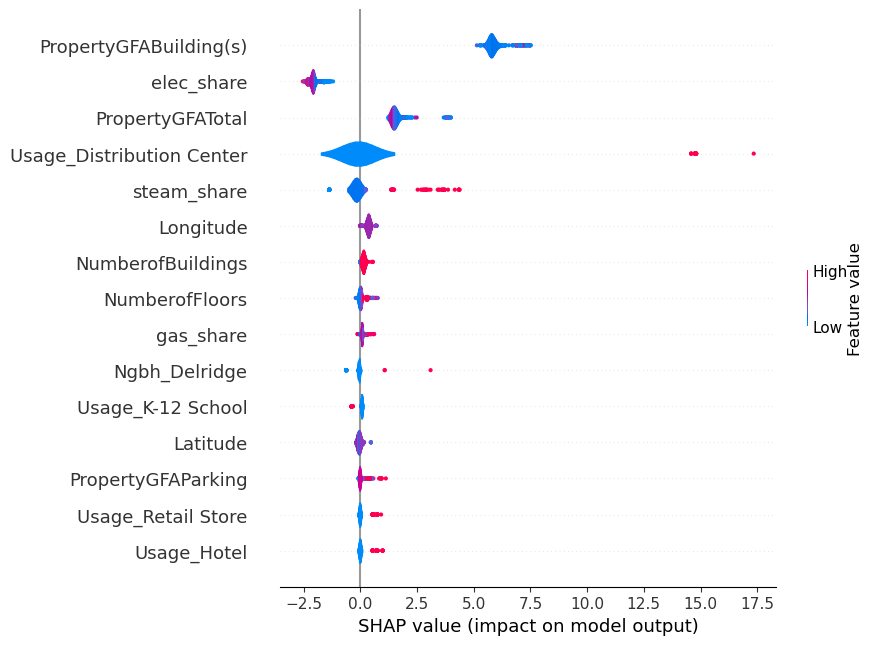

In [61]:
# Visualization
shap.summary_plot(shap_values,
                  plot_type = 'violin',
                  features = X_train,
                 max_display = 15)